In [25]:
import os.path

from model import get_models_and_path, get_vggs_and_path, get_resnets_and_path
import torch
import pandas as pd
from plot_and_print import plot_tile
import os
from PIL import Image
import matplotlib.pyplot as plt
from zennit.attribution import Gradient
import zennit as zen
from relevance import plot_relevance
from data_loader import TileLoader
import torchvision

import numpy as np

In [23]:
filenames = []
filenames.append("../results/p007/RUBCNL_results.csv")
filenames.append("../results/p009/RUBCNL_results.csv")
filenames.append("../results/p013/RUBCNL_results.csv")
filenames.append("../results/p014/RUBCNL_results.csv")
filenames.append("../results/p016/RUBCNL_results.csv")
filenames.append("../results/p020/RUBCNL_results.csv")
filenames.append("../results/p021/RUBCNL_results.csv")
filenames.append("../results/p025/RUBCNL_results.csv")
filenames.append("../results/p026/RUBCNL_results.csv")
df = pd.read_csv(filenames[0])
def cut_path(x):
    return x[3:]
new_col = df.path
new_col = new_col.apply(cut_path)
df.path = new_col


loader = TileLoader()

In [65]:
# best values first in list, ascending
def get_sorted_values_by_col(df, min, max, colname='../remote_models/res18/RUBCNL_Res18/Res18_ep_29.pt', gene="RUBCNL"):
    idx = df[gene].sort_values()[min:max].index.values

    vals_orig_by_range = df.iloc[idx]
    diff = vals_orig_by_range[gene] - vals_orig_by_range[colname]

    diff = diff.abs().sort_values()
    return df.iloc[diff.index]
small_vals  = get_sorted_values_by_col(df, 0, 100)
middle_vals = get_sorted_values_by_col(df, int(len(df)/2-50), int(len(df)/2+50))
big_vals    = get_sorted_values_by_col(df, -100, len(df))



5
5
5
5
5
5


In [104]:
df.head()

,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,...,../models/res18/res18_not_iced_e29.pt,../remote_models/res50/RUBCNL_Res50/MyNet2_ep_29.pt,../remote_models/res50/RUBCNL_Res50_freeze/Res50Dropout_ep_29.pt,../remote_models/res50/RUBCNL_Res50_drop_freeze/Res50Dropout_ep_29.pt,../remote_models/vgg13/dropout/VGG13_ep_29.pt,../remote_models/res18/RUBCNL_Res18/Res18_ep_29.pt,../remote_models/res18/RUBCNL_Res18_freeze/Res18_ep_29.pt,../remote_models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt,../remote_models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt,../remote_models/res18/RUBCNL_Res18_ciga_freeze_drop/Res18Dropout_ep_29.pt
0,0,0,0,0,0,0,0,0,0,0,...,-0.231876,0.302571,0.007148,0.007148,0.000444,-0.645175,-0.645175,0.156086,-0.163256,-0.163256
1,1,1,1,1,1,1,1,1,1,1,...,-0.883856,-1.041084,-0.446372,-0.446372,0.000444,-0.665046,-0.665046,-0.548805,-0.242207,-0.242207
2,2,2,2,2,2,2,2,2,2,2,...,-0.839116,-1.115019,-0.453465,-0.453465,0.000444,-0.582157,-0.582157,-0.782593,-0.304090,-0.304090
3,3,3,3,3,3,3,3,3,3,3,...,-0.928464,-1.046699,-0.409335,-0.409335,0.000444,-0.621982,-0.621982,-0.710011,-0.389516,-0.389516
4,4,4,4,4,4,4,4,4,4,4,...,-0.745390,-0.992694,-0.434605,-0.434605,0.000444,-0.577947,-0.577947,-0.668053,-0.238780,-0.238780


In [21]:
models = get_models_and_path()
resnets = get_resnets_and_path()
vggs = get_vggs_and_path()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [53]:
def get_grads(models, composite, idx, df, loader, gene="RUBCNL"):
    imgs = []
    for model,path in models:

        model.eval()
        img = loader.open(df.path[idx]).unsqueeze(0)
        with Gradient(model, composite) as attributor:
            out, grad = attributor(img)
        rel = plot_relevance(grad, filename=None, only_return=True)
        position = path.find('models') + len('models')
        imgs.append((rel,path[position:], df.iloc[idx][gene], out.item()))
    return imgs
id = big_vals.index.values[5]

can_vgg = zen.torchvision.VGGCanonizer()
"""
transform_norm = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))
composite_vgg = zen.composites.EpsilonGammaBox(low=low, high=high, canonizers=[can_vgg])"""

1


In [54]:
can_res = zen.torchvision.ResNetCanonizer()

composite_res = zen.composites.EpsilonPlusFlat(canonizers=[can_res])
composite_vgg = zen.composites.EpsilonPlusFlat(canonizers=[can_vgg])




3371


<Figure size 100000x100000 with 0 Axes>

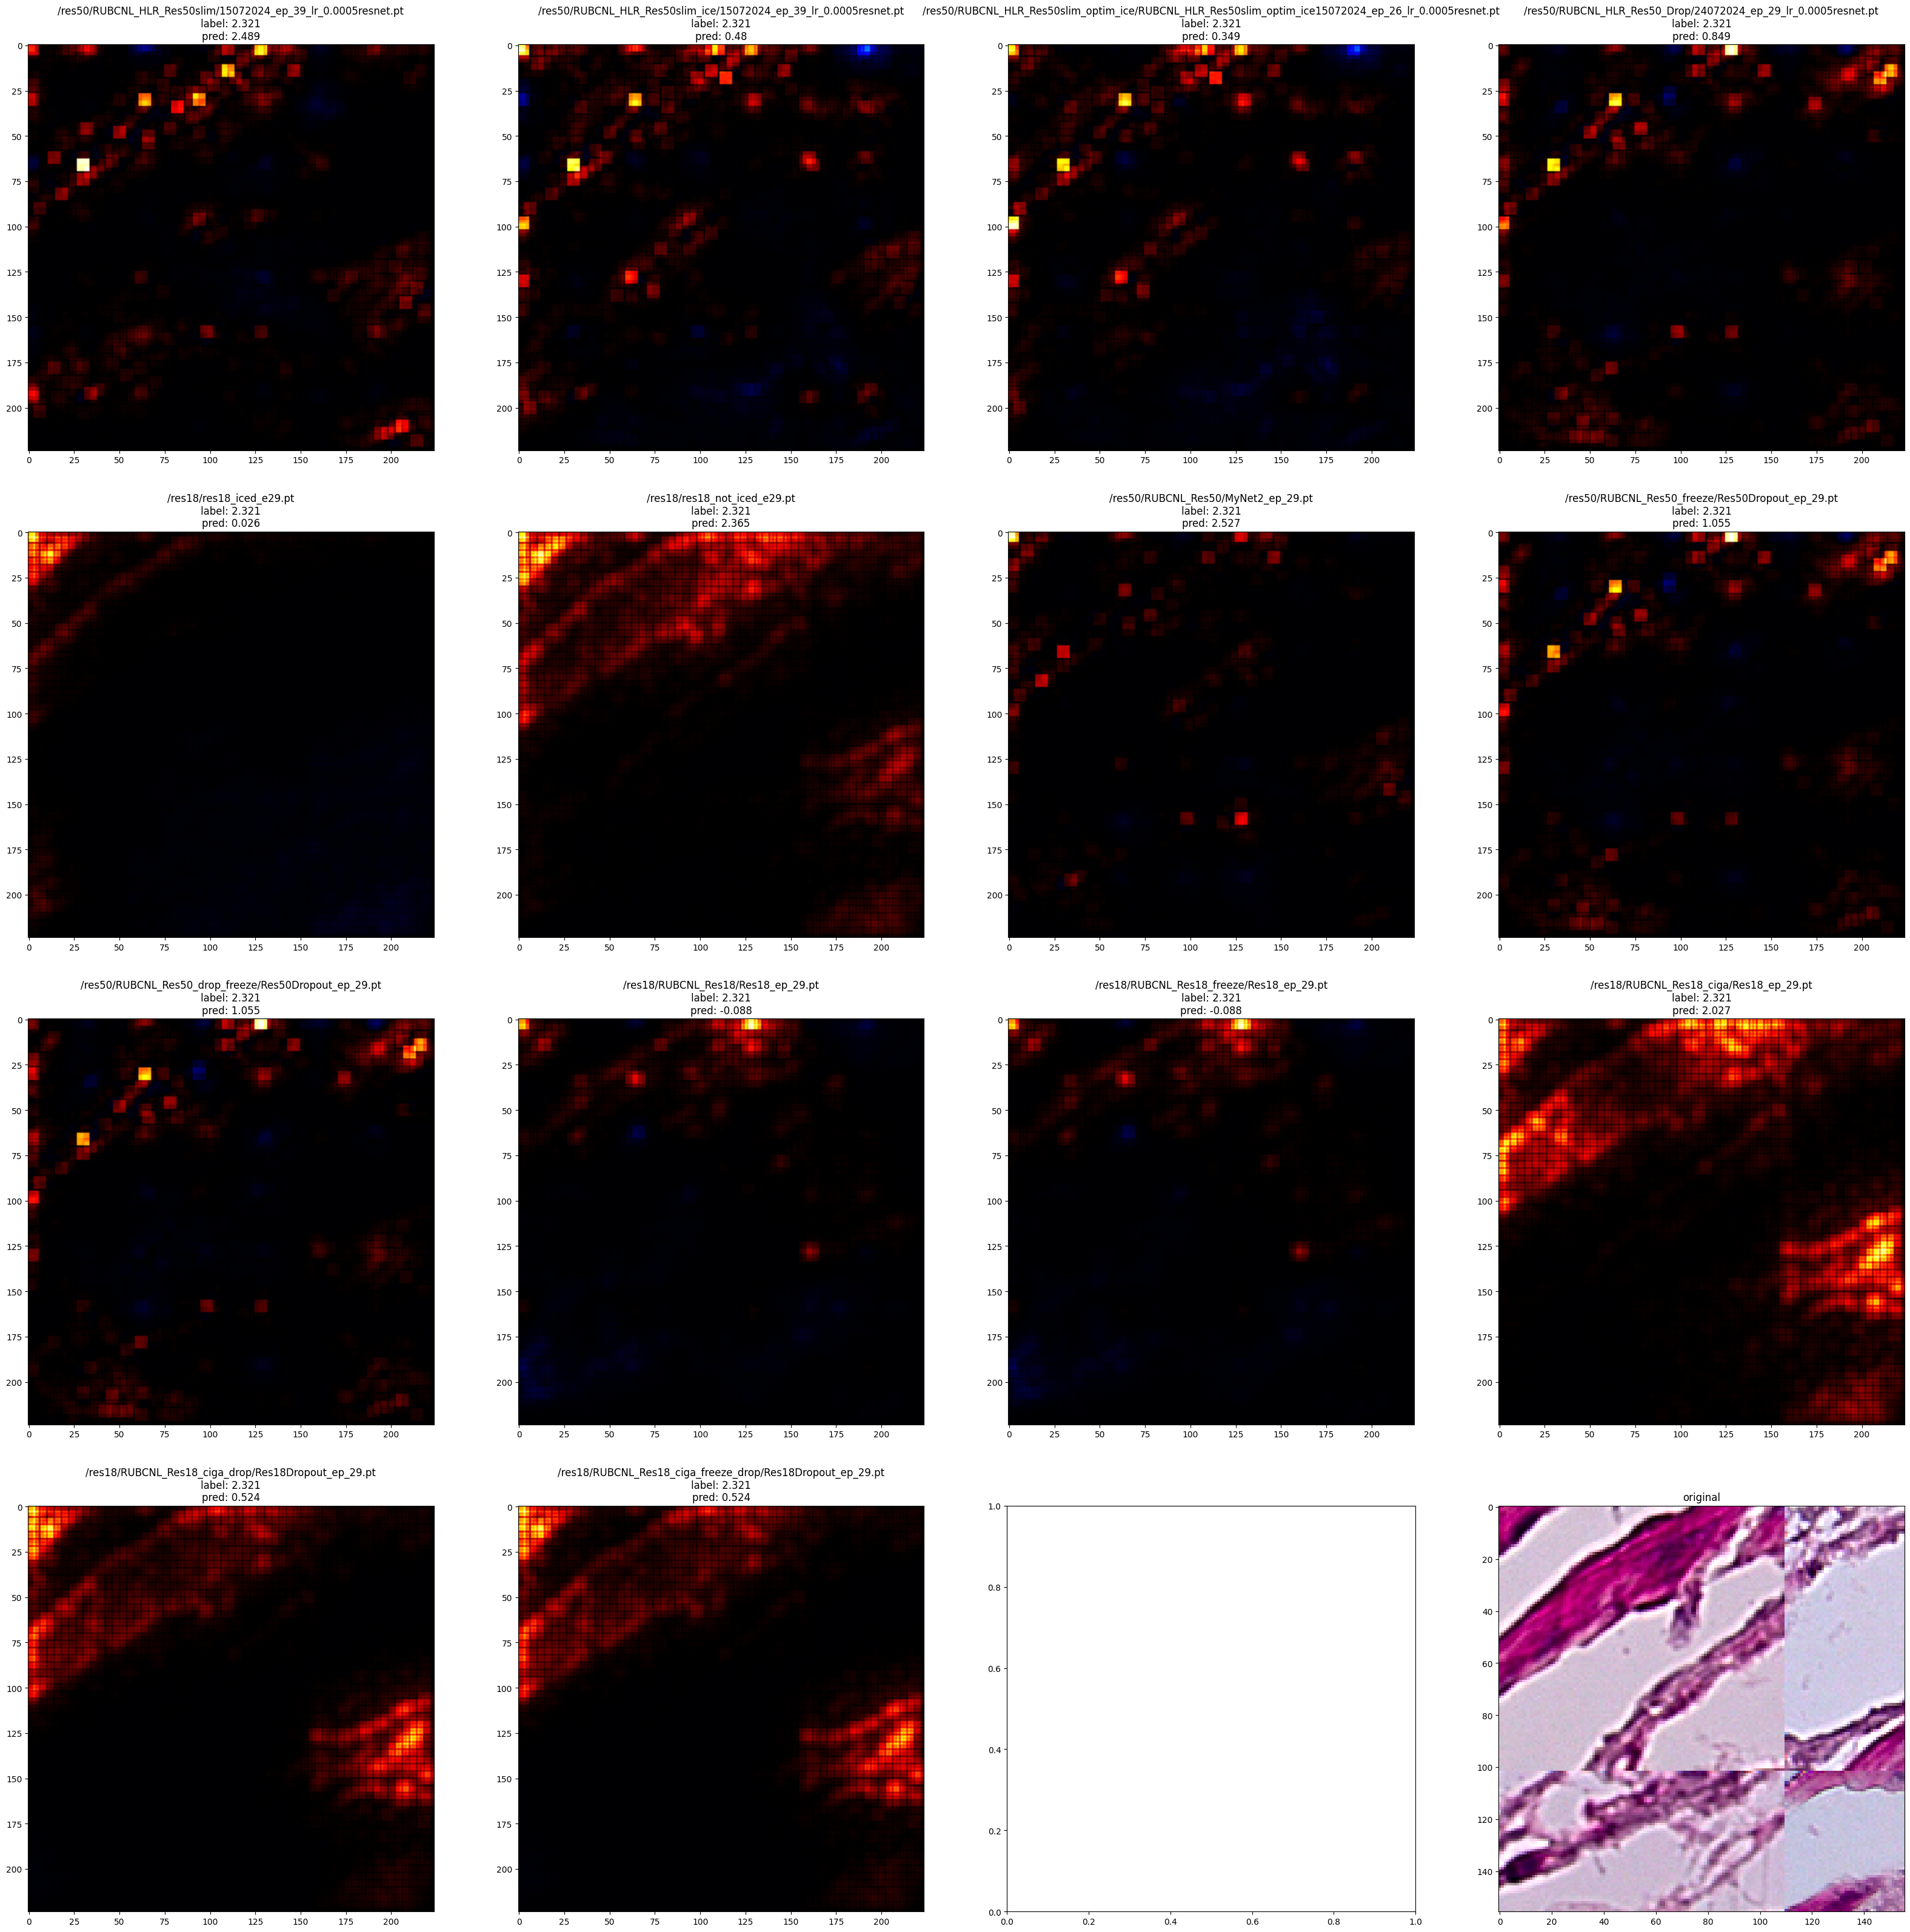

In [102]:

def plot_model_comparison(grads_res, grads_vgg, image_path, width=4, height=4, subplot_size=40):
    plt.figure(figsize=(1000,1000))
    f, ax = plt.subplots(height,width)
    f.set_figheight(subplot_size)
    f.set_figwidth(subplot_size)
    for i in range(len(grads_res)):
        ax[int(i/width),i%width].imshow(grads_res[i][0])
        ax[int(i/width),i%width].set_title(grads_res[i][1]+"\nlabel: "+str(round(grads_res[i][2], 3))+"\npred: "+str(round(grads_res[i][3], 3)))

    for i in range(len(grads_res), len(grads_vgg)):
        ax[int(i/width),i%width].imshow(grads_vgg[i][0])
        ax[int(i/width),i%width].set_title(grads_vgg[i][1]+"\nlabel: "+str(round(grads_vgg[i][2], 3))+"\npred: "+str(round(grads_vgg[i][3], 3)))
    img = Image.open(image_path)
    ax[-1,-1].imshow(img)
    ax[-1,-1].set_title('original')
    plt.show()
    
    
best = [small_vals[0:5], middle_vals[0:5], big_vals[0:5]]
worst = [small_vals[-5:], middle_vals[-5:], big_vals[-5:]]
# interesting:
interesting = []
interesting.append(best[0].index.values[1])
set = worst[2]
id = set.index.values[1]


#set = best[2]
#id = set.index.values[4]
row = df.iloc[id]
print(id)
grads_res = get_grads(resnets, composite_res, id, df, loader)
grads_vgg = get_grads(vggs, composite_vgg, id, df, loader)

plot_model_comparison(grads_res, grads_vgg, row.path)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
models = get_models_and_path(device)
tile = "path_to_tile"
# plot original


for m in models:
    hm = generate_heatmap_of_tile(tile)
    plot(hm)
    print(m.name)
    print(stats)